In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle
import scipy.optimize
import scipy.constants

In [4]:
# use uncertainties library (pip install uncertaintes)
from uncertainties import ufloat

In [5]:
from tqdm import tqdm_notebook as tqdm

In [6]:
hbarc = (scipy.constants.hbar * scipy.constants.speed_of_light
         / scipy.constants.mega / scipy.constants.electron_volt / scipy.constants.femto)

ainv = 2.333e3
lat_unit = hbarc/ainv
momega = 1.71153e3/ainv
mn = 0.95469e3/ainv
mpi = 0.146e3/ainv
L = 96
bin_num = 20 # number of the jackknife sample
spin = 2

In [7]:
m_red = mn * momega/(mn + momega)

In [9]:
print(f'N = {mn*ainv:3.2f} [MeV], Omega = {momega*ainv:3.2f} [MeV]')
print(f'redueced mass = {m_red*ainv:3.2f} [MeV]')

N = 954.69 [MeV], Omega = 1711.53 [MeV]
redueced mass = 612.85 [MeV]


In [10]:
V_fit = lambda p, x: p[0] * np.exp(-p[1]*x**2) + p[2] *  (
                1 - np.exp(-p[3]*x**2)) * (np.exp(-mpi*x)/(x+1.0e-5))**2

In [11]:
with open('pkls/FF_yukawa2_fit_result.pkl', 'rb') as fin:
    FF_yukawa2_prm_av, FF_yukawa2_prm_jk = pickle.load(fin)

check potential

Text(0.5,1.02,'$N\\Omega$($^{5}$S$_{2}$), $t/a = 12$')

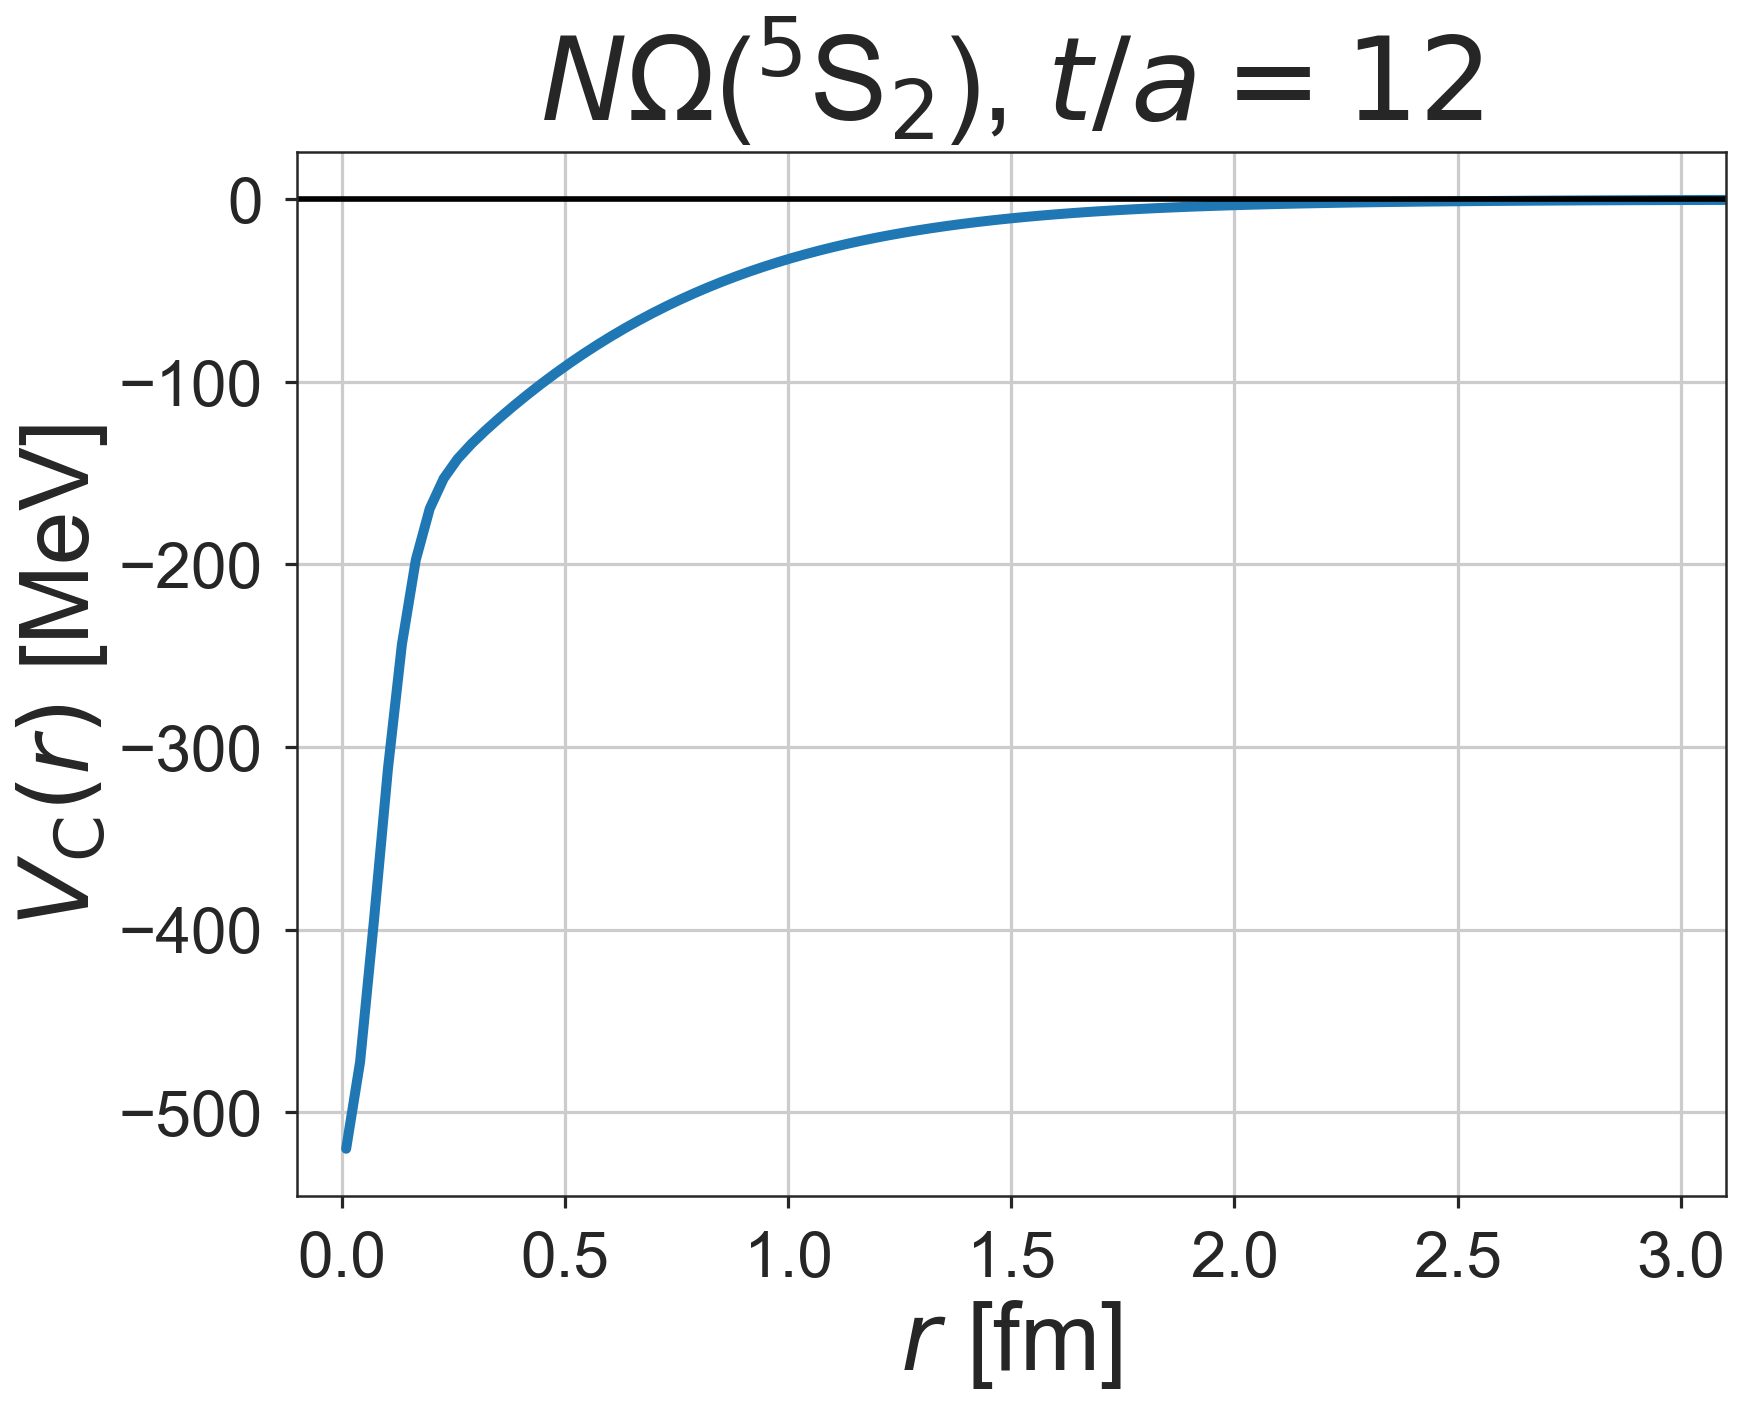

In [12]:
it = 12
xls = np.linspace(0.01, 3.10, 100)/lat_unit
fig, ax = plt.subplots()
ax.plot(xls*lat_unit, V_fit(FF_yukawa2_prm_av[it], xls)*ainv, lw=5)
ax.axhline(0, color='black')
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_\mathrm{C}(r)$ [MeV]', size=48)
ax.set_xlim(-0.10, 3.10)
ax.set_title(rf'$N\Omega$($^{{{spin*2+1:d}}}$S$_{{{spin:d}}}$), $t/a = {it:d}$', size=58, y=1.02)



Schroedinger Eq.

In [13]:
class Schroedinger_Eq(object):
    """Calculate the scattering phase shifts by solving Schroedinger Eq.
    
    All parameters are in lattice unit.
    """
    def __init__(self, pot, red_mass, r_min = 1.0e-5, r_max = 10/lat_unit, r_diff = 1.0e-3):
        self.pot = pot
        self.rs = np.arange(r_min, r_max, r_diff)
        self.red_mass = red_mass
        
    def sch_eq(self, uv, r, k2):
        """
        u = psi(r)/r with u(0) = 0
        solve
        u'' = - 2 mu (E - V(r)) u
        -->
        u' = v
        v' = - (k^2 - 2 mu V(r)) u
        """
        du = uv[1]
        dv = - (k2 - 2 * self.red_mass * self.pot(r)) * uv[0]
        return np.array([du, dv])
        
    def conv_delta(self, r, u, u_prime, k):
        return np.mod(np.arctan(k*u/u_prime) - k*r, np.pi)
    
    def plot_asymptotic_behavior(self, k2, u_prime_ini=1.0e-3):
        """
        This method checks convergence of the phase shift.
        """
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))
        fig, ax = plt.subplots()
        ax.plot(self.rs, self.conv_delta(self.rs, trj[:,0], trj[:,1], np.sqrt(k2)),
               label=r'$k^2 = {}$'.format(k2))
        ax.set_xlabel(r'$r$', size=48)
        ax.set_ylabel(r'$\delta$ [rad.]', size=48)
        leg = ax.legend(frameon=True)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        return ax
        
    def calc_phase_shift(self, k2, u_prime_ini=1.0e-3):
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))

        return self.conv_delta(self.rs[-1], trj[-1,0], trj[-1,1], np.sqrt(k2))       